# Anime Dataset


### Importuri

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy
import time



## Incarcare si afisare


In [2]:
db=pd.read_csv("top_anime_dataset.csv")
db

,anime_id,anime_url,image_url,name,english_name,japanese_names,score,genres,synopsis,type,...,producers,studios,source,duration,rating,rank,popularity,favorites,scored_by,members
0,52991,https://myanimelist.net/anime/52991/Sousou_no_...,https://cdn.myanimelist.net/images/anime/1015/...,Sousou no Frieren,Frieren: Beyond Journey's End,葬送のフリーレン,9.31,"Adventure, Drama, Fantasy",During their decade-long quest to defeat the D...,TV,...,"Aniplex, Dentsu, Shogakukan-Shueisha Productio...",Madhouse,Manga,24 min per ep,PG-13 - Teens 13 or older,1.0,160,63200,603520,1035677
1,5114,https://myanimelist.net/anime/5114/Fullmetal_A...,https://cdn.myanimelist.net/images/anime/1208/...,Fullmetal Alchemist: Brotherhood,Fullmetal Alchemist: Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,9.10,"Action, Adventure, Drama, Fantasy",After a horrific alchemy experiment goes wrong...,TV,...,"Aniplex, Square Enix, Mainichi Broadcasting Sy...",Bones,Manga,24 min per ep,R - 17+ (violence & profanity),2.0,3,231928,2196353,3483268
2,9253,https://myanimelist.net/anime/9253/Steins_Gate,https://cdn.myanimelist.net/images/anime/1935/...,Steins;Gate,Steins;Gate,STEINS;GATE,9.07,"Drama, Sci-Fi, Suspense",Eccentric scientist Rintarou Okabe has a never...,TV,...,"Frontier Works, Media Factory, Kadokawa Shoten...",White Fox,Visual novel,24 min per ep,PG-13 - Teens 13 or older,3.0,14,194507,1449844,2667979
3,60022,https://myanimelist.net/anime/60022/One_Piece_...,https://cdn.myanimelist.net/images/anime/1455/...,One Piece Fan Letter,NaN,ONE PIECE FAN LETTER,9.06,"Action, Adventure, Fantasy",Although the golden age of piracy is about to ...,TV Special,...,NaN,Toei Animation,Light novel,24 min,PG-13 - Teens 13 or older,4.0,2350,1970,68977,91278
4,38524,https://myanimelist.net/anime/38524/Shingeki_n...,https://cdn.myanimelist.net/images/anime/1517/...,Shingeki no Kyojin Season 3 Part 2,Attack on Titan Season 3 Part 2,進撃の巨人 Season3 Part.2,9.05,"Action, Drama, Suspense",Seeking to restore humanity's diminishing hope...,TV,...,"Production I.G, Dentsu, Mainichi Broadcasting ...",Wit Studio,Manga,23 min per ep,R - 17+ (violence & profanity),5.0,21,60500,1671010,2407861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,1595,https://myanimelist.net/anime/1595/Inma_Daitos...,https://cdn.myanimelist.net/images/anime/11/13...,Inma Daitoshi: Beast City,Beast City,淫魔大都市 BEAST CITY,5.57,Hentai,The modern age. Albeit tales of strange things...,OVA,...,"Comstock, Ltd.",C and R,Light novel,41 min per ep,Rx - Hentai,NaN,10513,9,883,3021
14996,49943,https://myanimelist.net/anime/49943/Cosplay_Ch...,https://cdn.myanimelist.net/images/anime/1384/...,Cosplay Change: Pure-kei Joshidaisei no Kiken ...,NaN,コスプレチェンジ ~ピュア系女子大生の危険な性癖~,5.57,Hentai,Aima Imoko is a young college student with a h...,OVA,...,NaN,Mousou Senka,Manga,20 min per ep,Rx - Hentai,NaN,9348,8,1675,4343
14997,38812,https://myanimelist.net/anime/38812/Botsuraku,https://cdn.myanimelist.net/images/anime/1301/...,Botsuraku,NaN,没落,5.57,NaN,A short music video of the song Botsuraku by t...,Music,...,Victor Entertainment,NaN,Original,1 min,G - All Ages,NaN,18697,0,196,364
14998,38914,https://myanimelist.net/anime/38914/Papa_no_March,https://cdn.myanimelist.net/images/anime/1553/...,Papa no March,Papa's March,パパのマーチ,5.57,NaN,Official music video directed by Mitsuyuki Ish...,Music,...,NaN,NaN,Original,3 min,G - All Ages,NaN,20187,0,132,273


### Eliminare coloane si randuri

Eliminarea coloanelor:
- anime_url: link-ul catre pagina anime ului
- image_url: link-ul catre imagine
- english_name: denumirea in limba engleza
- japanese_names: denumirea in limba japoneza
- synopsis: descrierea anime ului
- premiered: cand a aparut anime ul, eliminata deoarece peste 60% din valori sunt lipsa
- rank: are o corelatie de 0.98 cu score si contine 1800 de valori NaN, din aceasta cauza am decis eliminarea ei
- scored_by: are o corelatie de 0.99 cu 'members'

In [3]:
df = db.drop(['anime_url','image_url','english_name','japanese_names','synopsis','premiered','rank','scored_by','name'], axis=1)
df = df[df['rating'] != 'Rx - Hentai']

### NaN procent

In [4]:
for column in df.columns:
    percentage = df[column].isnull().mean()
    print(f'{column}: {percentage:.2%}')

anime_id: 0.00%
score: 0.00%
genres: 11.62%
type: 0.01%
episodes: 0.47%
producers: 37.90%
studios: 17.02%
source: 0.00%
duration: 0.00%
rating: 0.49%
popularity: 0.00%
favorites: 0.00%
members: 0.00%


### Coloana 'duration'
- extragerea duratiei unui episod din string, convertirea acestuia la float si pe urma la int
- inlocuirea valorilor NaN cu media valorilor din coloana

In [5]:
df['duration'] = df['duration'].str.extract(r'(\d+)').astype(float)
df['duration'] = df['duration'].fillna(df['duration'].mean()).astype(int)

### Coloana 'episodes'
- completare valori NaN cu media si conversia la int

In [6]:
df['episodes'] = df['episodes'].fillna(df['episodes'].mean()).astype(int)

### Coloana 'rating'
- maparea rating urilor si acordarea unui numar care semnifica varsta minima necesara pentru vizionarea animeului respectiv
- inlocuirea valorilor NaN din coloana rating cu 'Unkonown' si maparea acestuia cu -1

In [7]:
rating_mapping = {
    'G - All Ages': 0,
    'PG - Children': 8,
    'PG-13 - Teens 13 or older': 13,
    'R - 17+ (violence & profanity)': 17,
    'R+ - Mild Nudity': 18
}
df['rating'] = df['rating'].fillna('Unknown')
rating_mapping['Unknown'] = -1
df['rating'] = df['rating'].map(rating_mapping)


### Coloana 'source'

In [8]:

# Creează coloane binare pentru fiecare sursa folosind get_dummies
source_dummies = pd.get_dummies(df['source'], prefix='source').astype(int)

# Concatenează DataFrame-ul original cu DataFrame-ul surselor codificate
df = pd.concat([df, source_dummies], axis=1)

# Elimină coloana originală 'source'
df.drop(columns=['source'], inplace=True)

# Afișează DataFrame-ul rezultat
source_dummies.head()

,source_4-koma manga,source_Book,source_Card game,source_Game,source_Light novel,source_Manga,source_Mixed media,source_Music,source_Novel,source_Original,source_Other,source_Picture book,source_Radio,source_Unknown,source_Visual novel,source_Web manga,source_Web novel
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


### Coloana 'type'


In [9]:
# Creează coloane binare pentru fiecare tip folosind get_dummies
type_dummies = pd.get_dummies(df['type'], prefix='type').astype(int)

# Concatenează DataFrame-ul original cu DataFrame-ul tipurilor codificate
df = pd.concat([df, type_dummies], axis=1)

# Elimină coloana originală 'type'
df.drop(columns=['type'], inplace=True)

# Afișează DataFrame-ul rezultat
type_dummies.head()

,type_CM,type_Movie,type_Music,type_ONA,type_OVA,type_PV,type_Special,type_TV,type_TV Special
0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,1,0


### Coloana 'genres'

In [10]:
# Înlocuiește valorile NaN din coloana 'genres' cu 'Unknown' (dacă este necesar)
df['genres'] = df['genres'].fillna('Unknown')

# Împarte valorile din coloana 'genres' în liste de genuri
df['genres'] = df['genres'].str.split(', ')

# Creează coloane binare pentru fiecare gen folosind get_dummies
genres_dummies = df['genres'].str.join('|').str.get_dummies()

# Adaugă prefixul 'genres_' la fiecare coloană generată
genres_dummies = genres_dummies.add_prefix('genres_')

# Concatenează DataFrame-ul original cu DataFrame-ul genurilor codificate
df = pd.concat([df, genres_dummies], axis=1)

# Elimină coloana originală 'genres'
df.drop(columns=['genres'], inplace=True)

# Elimină coloana 'genres_Hentai' dacă este necesar
if 'genres_Hentai' in df.columns:
    df.drop(columns=['genres_Hentai'], inplace=True)

# Afișează DataFrame-ul rezultat
genres_dummies.head()

,genres_Action,genres_Adventure,genres_Avant Garde,genres_Award Winning,genres_Boys Love,genres_Comedy,genres_Drama,genres_Ecchi,genres_Erotica,genres_Fantasy,...,genres_Hentai,genres_Horror,genres_Mystery,genres_Romance,genres_Sci-Fi,genres_Slice of Life,genres_Sports,genres_Supernatural,genres_Suspense,genres_Unknown
0,0,1,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


### Coloana 'producers'

In [11]:
# Înlocuiește valorile NaN din coloana 'producers' cu 'Unknown'
df['producers'] = df['producers'].fillna('Unknown')

# Creează coloane binare pentru fiecare producător folosind get_dummies
producers_dummies = df['producers'].str.get_dummies(sep=', ')

# Adaugă prefixul 'producers_' la fiecare coloană generată
producers_dummies = producers_dummies.add_prefix('producers_')

# Concatenează DataFrame-ul original cu DataFrame-ul producătorilor codificați
df = pd.concat([df, producers_dummies], axis=1)

# Elimină coloana originală 'producers'
df.drop(columns=['producers'], inplace=True)

producers_dummies

,producers_.MP,producers_100studio,producers_10Gauge,producers_1IN,producers_1st PLACE,producers_1theK,producers_2.5D PRODUCTION,producers_2:10 Animation,producers_3xCube,producers_5pb.,...,producers_m.o.e.,producers_miHoYoAnime,producers_monofilmo,producers_nobishiro lab,producers_pH Studio,producers_qooop,producers_studioGONG,producers_syn Sophia,producers_tamakoshi,producers_voque ting
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14993,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14994,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Coloana 'studios'

In [12]:
# Înlocuiește valorile NaN din coloana 'studios' cu 'Unknown'
df['studios'] = df['studios'].fillna('Unknown')
# Creează coloane binare pentru fiecare studio folosind get_dummies
studios_dummies = df['studios'].str.get_dummies(sep=', ')
# Adaugă prefixul 'studios_' la fiecare coloană generată
studios_dummies = studios_dummies.add_prefix('studios_')
# Concatenează DataFrame-ul original cu DataFrame-ul studiourilor codificați
df = pd.concat([df, studios_dummies], axis=1)
# Elimină coloana originală 'studios'
df.drop(columns=['studios'], inplace=True)

studios_dummies

,studios_100studio,studios_10Gauge,studios_2:10 Animation,studios_5 Inc.,studios_717 Animation Studio,studios_7doc,studios_8bit,studios_A-1 Pictures,studios_A-Line,studios_A-Real,...,studios_production doA,studios_qmotri,studios_soket,studios_studio ALBLE,studios_studio MOTHER,studios_team Yamahitsuji,studios_teamKG,studios_ufotable,studios_uzupiyo Animation & Digital Works,studios_yell
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14993,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14994,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Stergere duplicate

In [13]:
df.duplicated().sum()  # 32 duplicate
df = df.drop_duplicates()

In [14]:
df

,anime_id,score,episodes,duration,rating,popularity,favorites,members,source_4-koma manga,source_Book,...,studios_production doA,studios_qmotri,studios_soket,studios_studio ALBLE,studios_studio MOTHER,studios_team Yamahitsuji,studios_teamKG,studios_ufotable,studios_uzupiyo Animation & Digital Works,studios_yell
0,52991,9.31,28,24,13,160,63200,1035677,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5114,9.10,64,24,17,3,231928,3483268,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9253,9.07,24,24,13,14,194507,2667979,0,0,...,0,0,0,0,0,0,0,0,0,0
3,60022,9.06,1,24,13,2350,1970,91278,0,0,...,0,0,0,0,0,0,0,0,0,0
4,38524,9.05,10,23,17,21,60500,2407861,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14993,36087,5.57,1,5,8,19849,0,291,0,0,...,0,0,0,0,0,0,0,0,0,0
14994,36095,5.57,1,5,13,18111,1,410,0,0,...,0,0,0,0,0,0,0,0,0,0
14997,38812,5.57,1,1,0,18697,0,364,0,0,...,0,0,0,0,0,0,0,0,0,0
14998,38914,5.57,1,3,0,20187,0,273,0,0,...,0,0,0,0,0,0,0,0,0,0


## Histograma

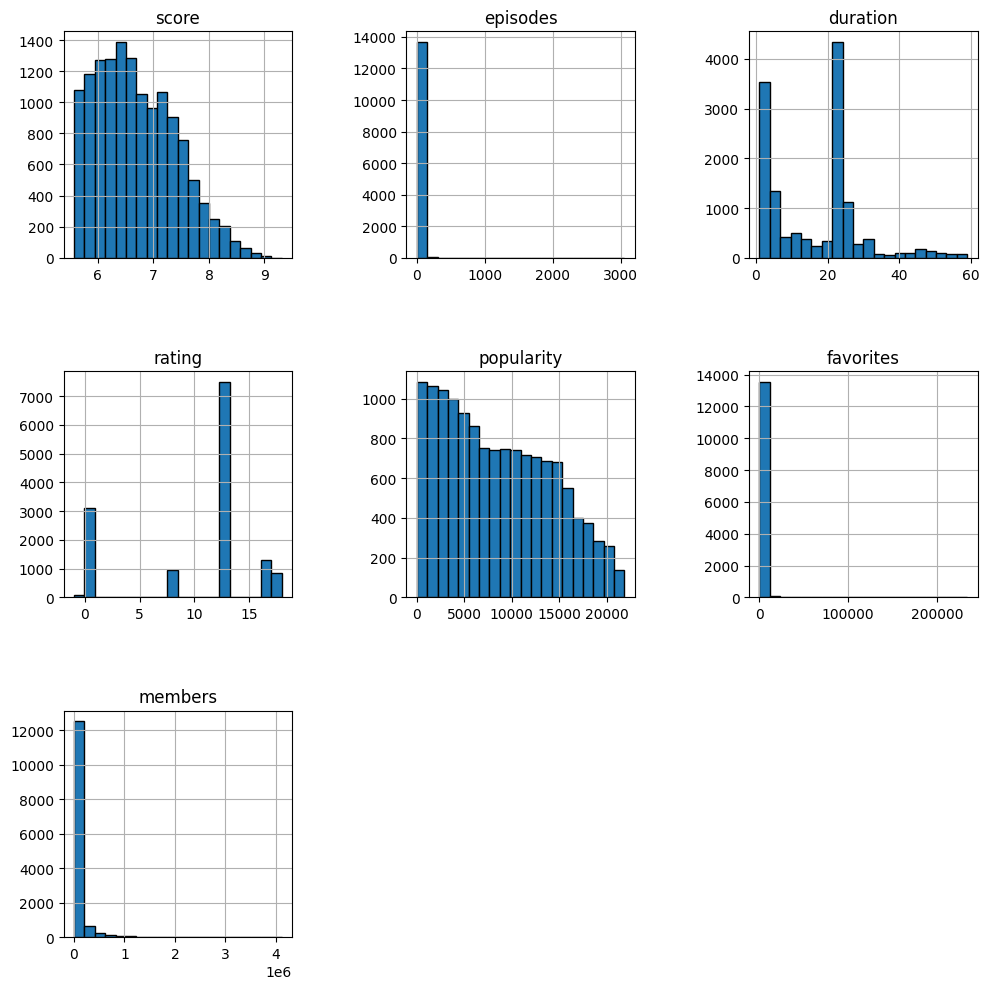

In [15]:
columns_to_plot = ['score', 'episodes', 'duration','rating','popularity','favorites','members']  
df[columns_to_plot].hist(figsize=(10, 10), bins=20, edgecolor='black')

plt.tight_layout()
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()

## Describe

In [16]:
df.describe()

,anime_id,score,episodes,duration,rating,popularity,favorites,members,source_4-koma manga,source_Book,...,studios_production doA,studios_qmotri,studios_soket,studios_studio ALBLE,studios_studio MOTHER,studios_team Yamahitsuji,studios_teamKG,studios_ufotable,studios_uzupiyo Animation & Digital Works,studios_yell
count,13760.000000,13760.000000,13760.000000,13760.000000,13760.000000,13760.000000,13760.000000,1.376000e+04,13760.000000,13760.000000,...,13760.000000,13760.000000,13760.000000,13760.000000,13760.000000,13760.000000,13760.000000,13760.000000,13760.000000,13760.000000
mean,25928.328997,6.697041,13.530887,16.615116,10.336555,8510.138081,871.306468,7.573820e+04,0.020422,0.006759,...,0.000291,0.000073,0.000073,0.000073,0.000581,0.000291,0.000291,0.005087,0.000073,0.000218
std,19287.980511,0.714481,52.224272,12.868265,6.068284,5674.029500,6368.066533,2.293387e+05,0.141442,0.081936,...,0.017048,0.008525,0.008525,0.008525,0.024106,0.017048,0.017048,0.071146,0.008525,0.014765
min,1.000000,5.570000,1.000000,1.000000,-1.000000,1.000000,0.000000,1.800000e+02,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6066.250000,6.120000,1.000000,3.000000,8.000000,3539.750000,1.000000,1.397000e+03,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,28622.000000,6.600000,3.000000,22.000000,13.000000,7859.500000,10.000000,6.854500e+03,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,40928.500000,7.210000,13.000000,24.000000,13.000000,13013.500000,107.000000,4.468150e+04,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,60988.000000,9.310000,3057.000000,59.000000,18.000000,21856.000000,234344.000000,4.116124e+06,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Nul

In [17]:
df.isnull().sum()

anime_id                                     0
score                                        0
episodes                                     0
duration                                     0
rating                                       0
                                            ..
studios_team Yamahitsuji                     0
studios_teamKG                               0
studios_ufotable                             0
studios_uzupiyo Animation & Digital Works    0
studios_yell                                 0
Length: 2315, dtype: int64

In [18]:
df.dtypes

anime_id                                       int64
score                                        float64
episodes                                       int64
duration                                       int64
rating                                         int64
                                              ...   
studios_team Yamahitsuji                       int64
studios_teamKG                                 int64
studios_ufotable                               int64
studios_uzupiyo Animation & Digital Works      int64
studios_yell                                   int64
Length: 2315, dtype: object

In [19]:
# Numărul de anime-uri de tip 'music' și gen 'Unknown'
music_unknown_count = df[(df['type_Music'] == 1) & (df['genres_Unknown'] == 1)].shape[0]
print(f"Numărul de anime-uri de tip 'music' și gen 'Unknown': {music_unknown_count}")

# Totalul anime-urilor de tip 'music'
total_music = df[df['type_Music'] == 1].shape[0]
print(f"Total anime-uri de tip 'music': {total_music}")

# Procentul de anime-uri de tip 'music' care au gen 'Unknown'
percentage = (music_unknown_count / total_music) * 100
print(f"Procentul de anime-uri de tip 'music' cu gen 'Unknown': {percentage:.2f}%")

Numărul de anime-uri de tip 'music' și gen 'Unknown': 1075
Total anime-uri de tip 'music': 1478
Procentul de anime-uri de tip 'music' cu gen 'Unknown': 72.73%


In [20]:
# Eliminarea anime-urilor de tip 'music' și gen 'Unknown'
df = df[~((df['type_Music'] == 1) & (df['genres_Unknown'] == 1))]
print(f"Dimensiunea dataset-ului după eliminare: {df.shape}")

Dimensiunea dataset-ului după eliminare: (12685, 2315)


In [21]:
# Exclude coloanele care încep cu 'type_', 'studios_', 'producers_' sau 'genres_'
columns_to_exclude = [col for col in df.columns if col.startswith(( 'studios_', 'producers_'))]

# Exclude coloanele care nu sunt numerice
numeric_df = df.drop(columns=columns_to_exclude).select_dtypes(include=['number'])

# Calculează matricea de corelație doar pentru coloanele rămase
correlation_matrix = numeric_df.corr()

# Afișează matricea de corelație
correlation_matrix

,anime_id,score,episodes,duration,rating,popularity,favorites,members,source_4-koma manga,source_Book,...,genres_Gourmet,genres_Horror,genres_Mystery,genres_Romance,genres_Sci-Fi,genres_Slice of Life,genres_Sports,genres_Supernatural,genres_Suspense,genres_Unknown
anime_id,1.000000,-0.028941,-0.062702,-0.193865,0.008904,0.171990,-0.023182,0.004120,0.003209,-0.052301,...,0.042769,-0.049591,-0.022141,-0.092821,-0.187478,0.049095,-0.022422,-0.007049,0.024727,0.064626
score,-0.028941,1.000000,0.029822,0.092810,0.301455,-0.671263,0.279841,0.432471,0.005394,-0.014267,...,0.002604,-0.019196,0.138905,0.115734,0.003030,-0.029821,0.044792,0.082158,0.117744,-0.119221
episodes,-0.062702,0.029822,1.000000,0.019730,-0.068517,0.000898,0.054025,0.036678,-0.007980,0.000523,...,0.028840,-0.013992,-0.021448,-0.016795,-0.010894,-0.000310,0.008563,-0.011283,-0.014582,0.016291
duration,-0.193865,0.092810,0.019730,1.000000,0.163542,-0.186963,0.047749,0.093535,-0.058448,-0.031618,...,-0.003860,0.049153,0.036887,0.066090,0.084169,-0.063316,0.030418,0.023771,0.015853,-0.032495
rating,0.008904,0.301455,-0.068517,0.163542,1.000000,-0.494045,0.089623,0.198312,0.019932,-0.083525,...,-0.041691,0.120411,0.138328,0.124310,0.127181,-0.177222,-0.009059,0.116416,0.150686,-0.144532
popularity,0.171990,-0.671263,0.000898,-0.186963,-0.494045,1.000000,-0.198579,-0.434939,-0.041960,0.039037,...,0.009999,-0.040301,-0.119148,-0.200355,-0.058475,0.080019,-0.014269,-0.106009,-0.125871,0.167348
favorites,-0.023182,0.279841,0.054025,0.047749,0.089623,-0.198579,1.000000,0.771356,-0.008218,-0.011385,...,-0.006847,0.010273,0.025300,0.023602,-0.009237,-0.028339,-0.008149,0.035267,0.128720,-0.028730
members,0.004120,0.432471,0.036678,0.093535,0.198312,-0.434939,0.771356,1.000000,-0.004183,-0.025482,...,0.004458,0.033318,0.055868,0.101670,-0.033554,-0.056832,-0.016349,0.076044,0.180145,-0.065596
source_4-koma manga,0.003209,0.005394,-0.007980,-0.058448,0.019932,-0.041960,-0.008218,-0.004183,1.000000,-0.012865,...,0.017145,-0.025353,-0.039335,-0.029162,-0.069761,0.183532,-0.014002,-0.035567,-0.025760,-0.025752
source_Book,-0.052301,-0.014267,0.000523,-0.031618,-0.083525,0.039037,-0.011385,-0.025482,-0.012865,1.000000,...,0.000736,-0.008726,-0.018540,-0.016229,-0.026915,0.024093,-0.018335,-0.010266,-0.014629,0.015080


### Heatmap

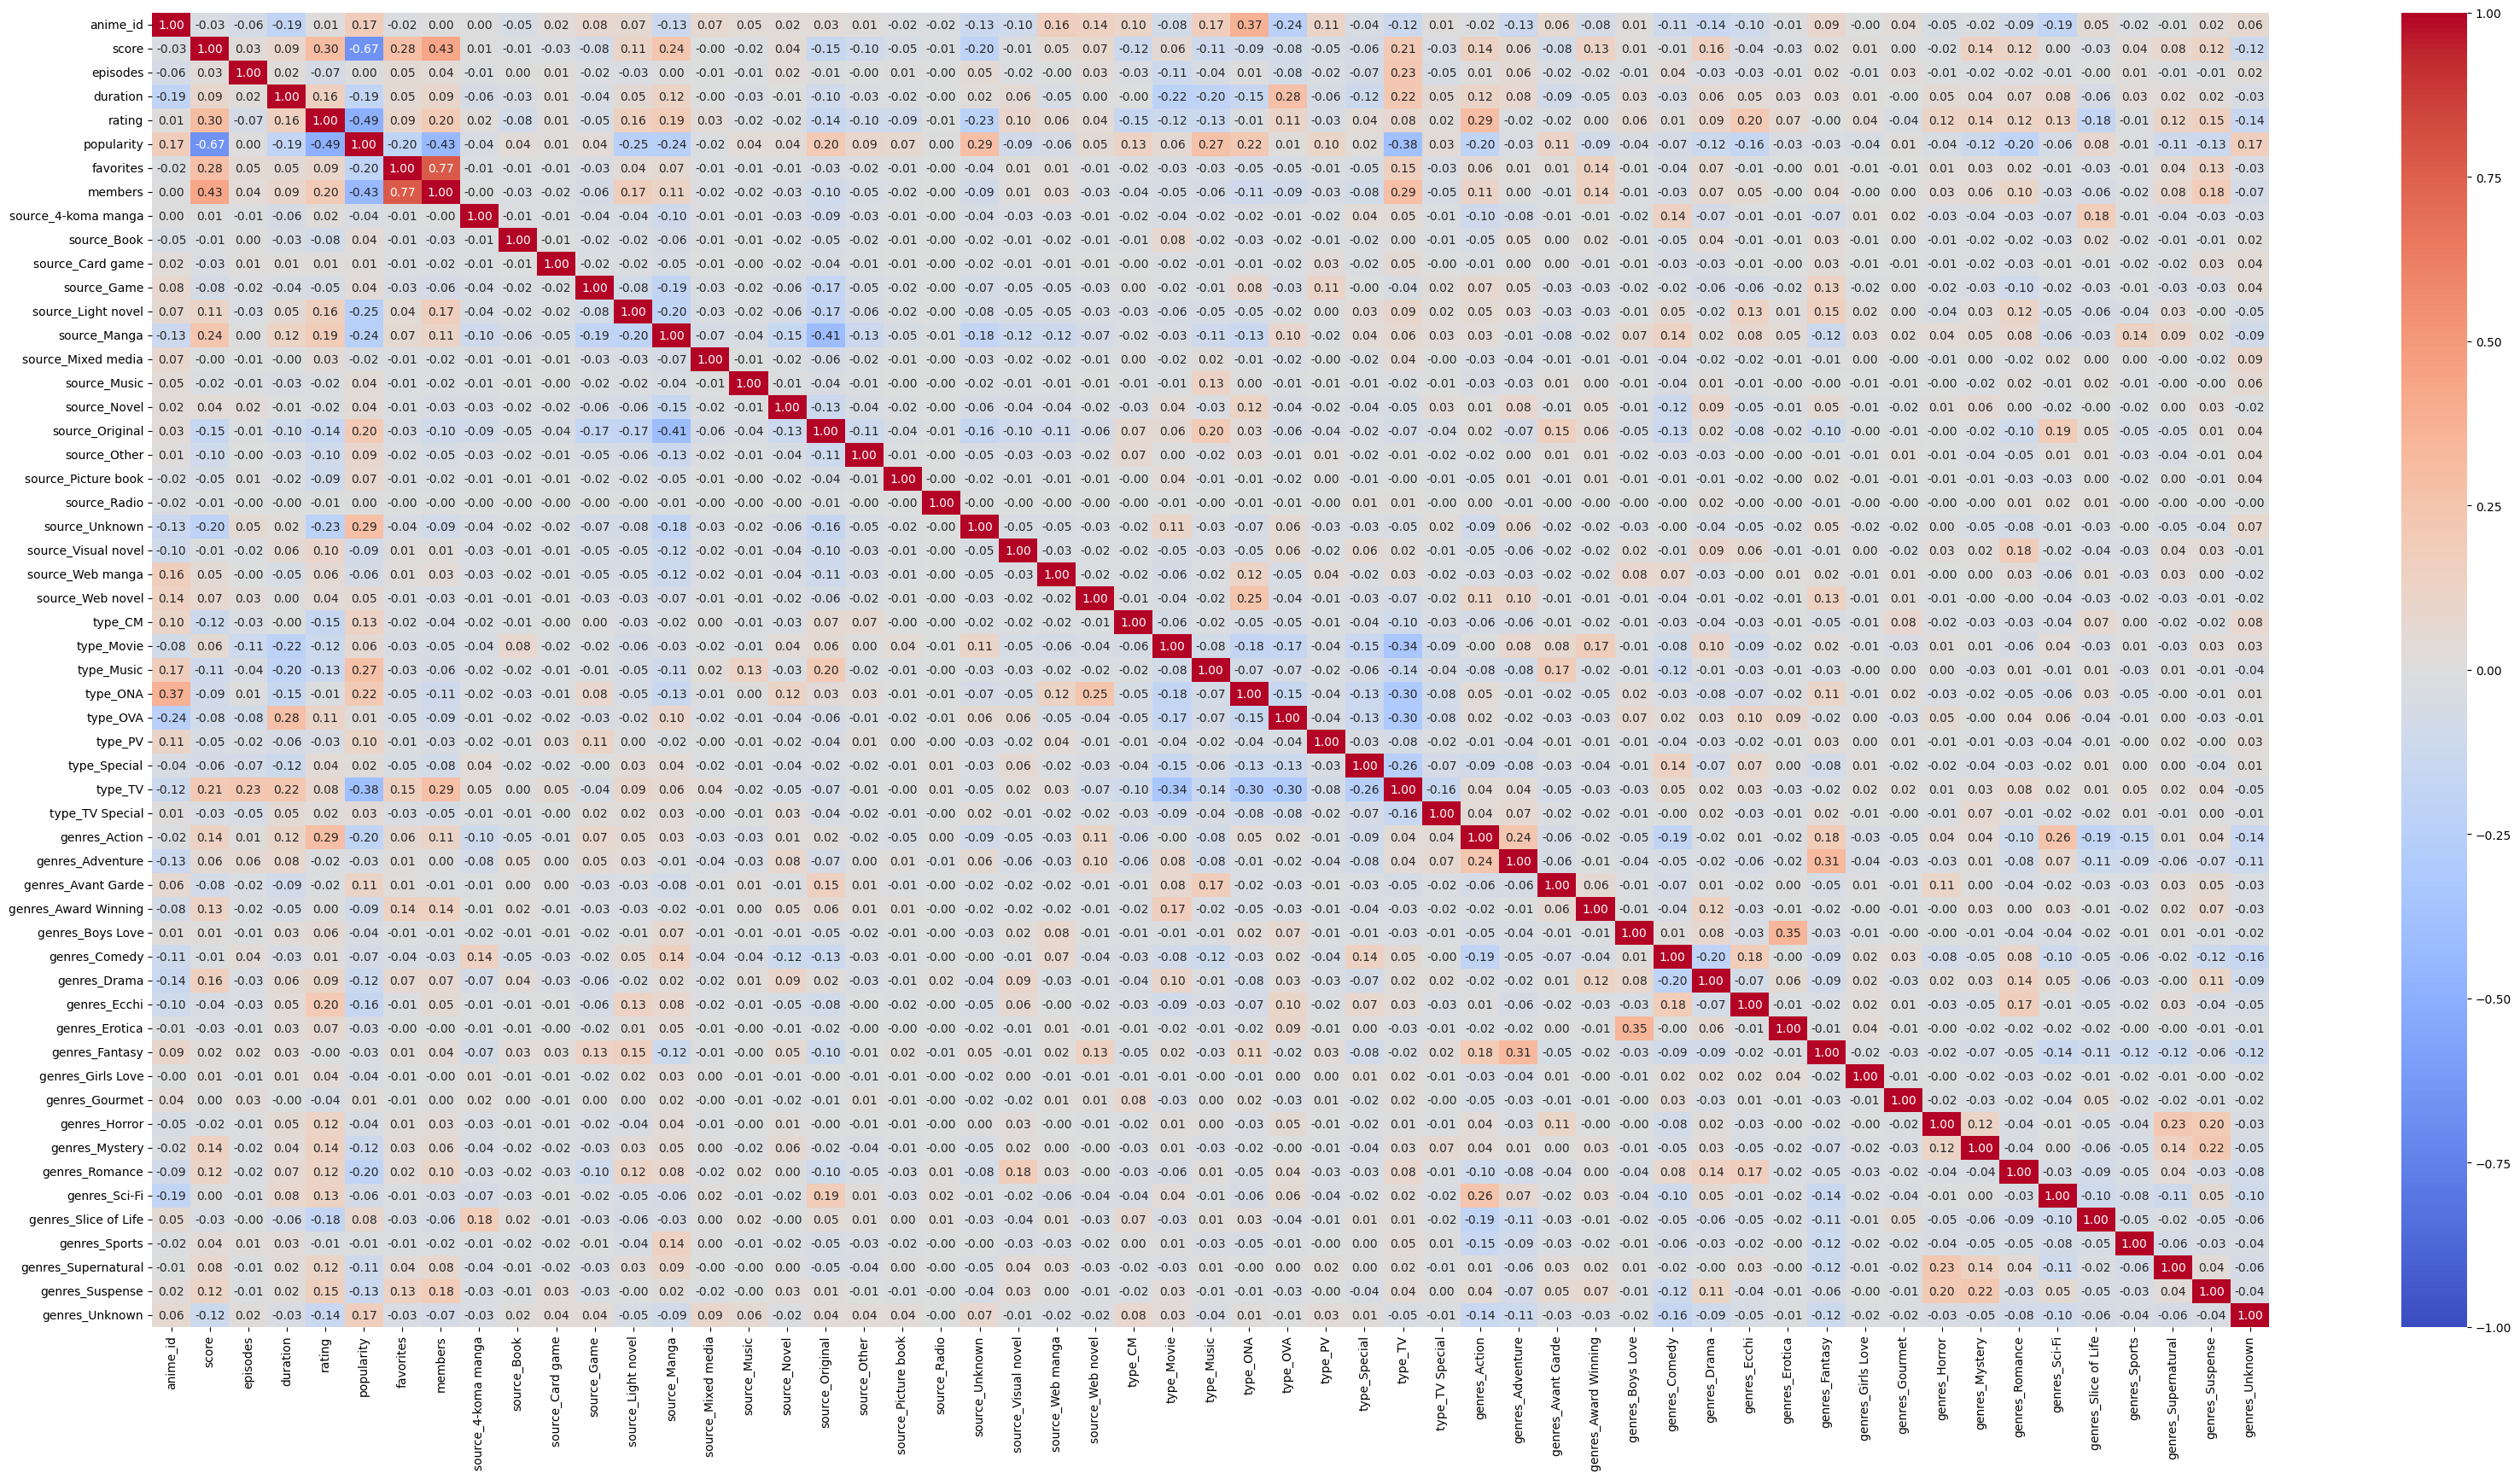

In [22]:

# Creează heatmap-ul
plt.figure(figsize=(40, 20))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)

# Afișează heatmap-ul
plt.show()

### Explicare corelatii
- -0.67 'score' cu 'popularity': pe masura ce valoarea din popularity creste, adica devine mai putin popular, valoarea 1 insemnand cel mai popular, valoarea din coloana score tinde sa scada. Anime urile mai populare tind sa aiba un scor mai mare, fiind mai apreciate de public. Anime urile mai putin populare tind sa aiba scoruri mai mici, ce poate insemna o calitate mai scazuta sau audienta mai mica. Acestea sunt adesea legate, dar exista si factori subiectivi care influenteaza cele 2 variabile. Un anime poate avea un scor mai mare daca a fost votat de un numar mai restrans de oameni, decat daca ar fi fost votat de mai multi, si popularitatea acestuia ar fi mai mica. Sau ar putea sa creasca si scor ul cu cat este votat de mai multi oameni.
- 0.77 'members cu 'favorites': anime urile care au un numar mare de membrii ( au adaugat anime ul in listele lor de 'watching', 'completed', etc ), tind sa fie mai apreciate si adaugat in listele de favorite ale persoanelor. Un anime care are multi membrii este de regula unul popular, astfel exista mai multe sanse ca cineva sa-l considere unul din preferatele sale. Dintr-un anumit numar de membrii, doar cativa il adauga ca si favorit. Daca acest raport se pastreaza, atunci un numar mare de membrii va face ca anime ul respectiv sa fie adaugat de mai multi oameni in lista de favorite. Aceasta corelatie nu implica neaparat o cauzalitate, si arata tendinta ca anime urile care au un numar mai mare de membrii, sunt adaugate de mai multe persoane la favorite.


In [23]:
for column in df.columns:
    percentage = df[column].isnull().mean()
    print(f'{column}: {percentage:.2%}')

anime_id: 0.00%
score: 0.00%
episodes: 0.00%
duration: 0.00%
rating: 0.00%
popularity: 0.00%
favorites: 0.00%
members: 0.00%
source_4-koma manga: 0.00%
source_Book: 0.00%
source_Card game: 0.00%
source_Game: 0.00%
source_Light novel: 0.00%
source_Manga: 0.00%
source_Mixed media: 0.00%
source_Music: 0.00%
source_Novel: 0.00%
source_Original: 0.00%
source_Other: 0.00%
source_Picture book: 0.00%
source_Radio: 0.00%
source_Unknown: 0.00%
source_Visual novel: 0.00%
source_Web manga: 0.00%
source_Web novel: 0.00%
type_CM: 0.00%
type_Movie: 0.00%
type_Music: 0.00%
type_ONA: 0.00%
type_OVA: 0.00%
type_PV: 0.00%
type_Special: 0.00%
type_TV: 0.00%
type_TV Special: 0.00%
genres_Action: 0.00%
genres_Adventure: 0.00%
genres_Avant Garde: 0.00%
genres_Award Winning: 0.00%
genres_Boys Love: 0.00%
genres_Comedy: 0.00%
genres_Drama: 0.00%
genres_Ecchi: 0.00%
genres_Erotica: 0.00%
genres_Fantasy: 0.00%
genres_Girls Love: 0.00%
genres_Gourmet: 0.00%
genres_Horror: 0.00%
genres_Mystery: 0.00%
genres_Romanc

### Entropia


In [24]:
# Calcularea entropie
def calculate_entropy(column):
    # Obține valorile unice și numărul de apariții
    value_counts = column.value_counts()
    # Calculează entropia
    entropy_value = entropy(value_counts, base=2)
    
    return entropy_value
#episoade
episodes_entropy = calculate_entropy(df['episodes'])
print(f"Entropy for episodes: {episodes_entropy:.4f}")
#durata
duration_entropy = calculate_entropy(df['duration'])
print(f"Entropy for duration: {duration_entropy:.4f}")
#rating
rating_entropy = calculate_entropy(df['rating'])
print(f"Entropy for rating: {rating_entropy:.4f}")
#scor
score_bins = pd.cut(df['score'], bins=[5, 6, 7, 8, 9, 10], right=False)
score_entropy = calculate_entropy(score_bins)
print(f"Entropy for score: {score_entropy:.4f}")
#popularitate
popularity_bins = pd.cut(df['popularity'], bins=10, right=False)  # 10 bin-uri egale
popularity_entropy = calculate_entropy(popularity_bins)
print(f"Entropy for popularity: {popularity_entropy:.4f}")
#favorite
favorites_bins = pd.cut(df['favorites'], bins=10, right=False)  # 10 bin-uri egale
favorites_entropy = calculate_entropy(favorites_bins)
print(f"Entropy for favorites: {favorites_entropy:.4f}")
#membri
members_bins = pd.cut(df['members'], bins=10, right=False)  # 10 bin-uri egale
members_entropy = calculate_entropy(members_bins)
print(f"Entropy for members: {members_entropy:.4f}")



Entropy for episodes: 3.7308
Entropy for duration: 4.4452
Entropy for rating: 1.8442
Entropy for score: 1.7105
Entropy for popularity: 3.1160
Entropy for favorites: 0.0874
Entropy for members: 0.3605


### Gini index

In [25]:
# Funcție pentru calcularea Gini Index
def calculate_gini(column):
    # Calculează frecvențele relative ale valorilor unice
    value_counts = column.value_counts(normalize=True)
    # Calculează indicele Gini
    gini = 1 - np.sum(value_counts**2)
    return gini

#episoade
episodes_gini = calculate_gini(df['episodes'])
print(f"Gini Index for episodes: {episodes_gini:.4f}")
#durata
duration_gini = calculate_gini(df['duration'])
print(f"Gini Index for duration: {duration_gini:.4f}")
#rating
rating_gini = calculate_gini(df['rating'])
print(f"Gini Index for rating: {rating_gini:.4f}")
#scor
score_bins = pd.cut(df['score'], bins=[5, 6, 7, 8, 9, 10], right=False)
score_gini = calculate_gini(score_bins)
print(f"Gini Index for score: {score_gini:.4f}")
#popularitate
popularity_bins = pd.cut(df['popularity'], bins=10, right=False)  # 10 bin-uri egale
popularity_gini = calculate_gini(popularity_bins)
print(f"Gini Index for popularity: {popularity_gini:.4f}")
#favorite
favorites_bins = pd.cut(df['favorites'], bins=10, right=False)  # 10 bin-uri egale
favorites_gini = calculate_gini(favorites_bins)
print(f"Gini Index for favorites: {favorites_gini:.4f}")
#membri
members_bins = pd.cut(df['members'], bins=10, right=False)  # 10 bin-uri egale
members_gini = calculate_gini(members_bins)
print(f"Gini Index for members: {members_gini:.4f}")


Gini Index for episodes: 0.8077
Gini Index for duration: 0.9161
Gini Index for rating: 0.6321
Gini Index for score: 0.6563
Gini Index for popularity: 0.8763
Gini Index for favorites: 0.0174
Gini Index for members: 0.0915


In [26]:
print(sorted(df['members'].unique().tolist()))
print(len(df['members'].unique()))
print(sorted(df['favorites'].unique().tolist()))
print(len(df['favorites'].unique()))
print(sorted(df['popularity'].unique().tolist()))
print(len(df['popularity'].unique()))
print(sorted(df['rating'].unique().tolist()))
print(df['rating'].value_counts())

[188, 204, 206, 210, 211, 212, 214, 215, 219, 220, 222, 225, 226, 227, 229, 230, 231, 233, 234, 235, 237, 239, 240, 241, 242, 243, 244, 247, 249, 251, 252, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 268, 269, 270, 271, 272, 273, 275, 276, 277, 278, 279, 280, 281, 282, 284, 285, 286, 288, 289, 290, 291, 293, 294, 296, 297, 299, 300, 301, 302, 303, 304, 305, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 327, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 340, 341, 342, 343, 344, 345, 346, 347, 348, 350, 351, 352, 354, 355, 356, 357, 359, 360, 361, 362, 364, 365, 367, 369, 370, 371, 372, 373, 374, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 418, 419, 420, 421, 422, 423, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443,

### Random forest regresie

In [27]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 1. Încărcarea datelor
# Presupunem că datasetul a fost deja curățat și one-hot encoded.
# De exemplu, dacă ai un CSV:
# df = pd.read_csv('cale_catre_dataset.csv')

# 2. Pregătirea datelor:
# Eliminăm coloana 'anime_id' și folosim 'score' ca țintă.
X = df.drop(columns=['score', 'anime_id'])
y = df['score']

# 3. Împărțirea setului de date în 70%-20%-10%
# Mai întâi, extragem 10% pentru setul de validare.
X_temp_forest, X_val_forest, y_temp_forest, y_val_forest = train_test_split(X, y, test_size=0.10, random_state=42)

# Din restul de 90%, împărțim în antrenare (70% din total) și testare (20% din total)
# Calculăm proporția setului de testare: 20/90 ≈ 0.222
X_train_forest, X_test_forest, y_train_forest, y_test_forest = train_test_split(X_temp_forest, y_temp_forest, test_size=20/90, random_state=42)

# 4. Construirea modelului Random Forest și optimizarea hiperparametrilor:
rf = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Folosim GridSearchCV pentru a căuta cea mai bună combinație de parametri
grid_search = GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error',  # Scorul este negativ pentru MSE; ulterior se aplică o transformare
                           n_jobs=-1,
                           verbose=1)
grid_search.fit(X_train_forest, y_train_forest)

print("Cei mai buni hiperparametri găsiți:", grid_search.best_params_)
print("Scorul CV (RMSE):", np.sqrt(-grid_search.best_score_))

# Modelul optimizat
best_rf = grid_search.best_estimator_

# 5. Evaluarea pe setul de test
y_pred_test_forest = best_rf.predict(X_test_forest)
mse_test_forest = mean_squared_error(y_test_forest, y_pred_test_forest)
r2_test_forest = r2_score(y_test_forest, y_pred_test_forest)
print("\nEvaluarea pe setul de test:")
print("MSE:", mse_test_forest)
print("R^2:", r2_test_forest)

# 6. Evaluarea pe setul de validare
y_pred_val_forest = best_rf.predict(X_val_forest)
mse_val_forest = mean_squared_error(y_val_forest, y_pred_val_forest)
r2_val_forest = r2_score(y_val_forest, y_pred_val_forest)
print("\nEvaluarea pe setul de validare:")
print("MSE:", mse_val_forest)
print("R^2:", r2_val_forest)


Fitting 5 folds for each of 32 candidates, totalling 160 fits
Cei mai buni hiperparametri găsiți: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Scorul CV (RMSE): 0.38994080600743397

Evaluarea pe setul de test:
MSE: 0.14233951444324008
R^2: 0.7283652678552406

Evaluarea pe setul de validare:
MSE: 0.13967112714342006
R^2: 0.7418147147744516


In [28]:
# Afișează câteva exemple de valori reale și prezise
comparison_df = pd.DataFrame({
    'Valoare reală': y_test_forest.values,
    'Valoare prezisă': y_pred_test_forest
})

# Afișează primele 10 exemple
print(comparison_df.head(1000).sort_values(by='Valoare reală', ascending=False))

     Valoare reală  Valoare prezisă
672           9.06          7.93575
640           9.00          8.54985
584           8.76          8.20035
735           8.73          8.32515
744           8.72          8.14825
..             ...              ...
223           5.58          6.14470
435           5.58          6.21845
378           5.58          6.21515
418           5.58          5.88525
403           5.58          6.35685

[1000 rows x 2 columns]


### XGBoost regresie

In [46]:
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

# Se presupune că 'df' este DataFrame-ul deja preprocesat, cu one-hot encoding aplicat,
# iar coloanele 'anime_id' și 'score' sunt prezente.
X = df.drop(columns=['score', 'anime_id'])
y = df['score']

# Împărțirea datelor: mai întâi extragem 10% pentru validare
X_temp_xg, X_val_xg, y_temp_xg, y_val_xg = train_test_split(X, y, test_size=0.10, random_state=42)

# Din restul de 90%, folosim aproximativ 77.8% pentru antrenare și 22.2% pentru testare (20/90)
X_train_xg, X_test_xg, y_train_xg, y_test_xg = train_test_split(X_temp_xg, y_temp_xg, test_size=20/90, random_state=42)

# Definirea modelului XGBoost pentru regresie
xgb_reg = xgb.XGBRegressor(random_state=42, objective='reg:squarederror')

# Set de hiperparametri pentru tuning
param_grid_xgb = {
    'n_estimators': [200, 300, 500],
    'max_depth': [7, 10, 13],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.6, 0.7, 0.8]
}

# GridSearchCV pentru optimizarea hiperparametrilor
grid_search_xgb = GridSearchCV(estimator=xgb_reg,
                               param_grid=param_grid_xgb,
                               cv=5,
                               scoring='neg_mean_squared_error',
                               n_jobs=-1,
                               verbose=1)

grid_search_xgb.fit(X_train_xg, y_train_xg)

print("Cei mai buni parametrii pentru XGBoost:", grid_search_xgb.best_params_)
print("Scorul CV XGBoost (RMSE):", np.sqrt(-grid_search_xgb.best_score_))

# Obținem modelul optimizat
best_xgb = grid_search_xgb.best_estimator_

# Evaluare pe setul de test
y_pred_test_xgb = best_xgb.predict(X_test_xg)
mse_test_xgb = mean_squared_error(y_test_xg, y_pred_test_xgb)
r2_test_xgb = r2_score(y_test_xg, y_pred_test_xgb)
print("\nEvaluare pe setul de test (XGBoost):")
print("MSE:", mse_test_xgb)
print("R²:", r2_test_xgb)

# Evaluare pe setul de validare
y_pred_val_xgb = best_xgb.predict(X_val_xg)
mse_val_xgb = mean_squared_error(y_val_xg, y_pred_val_xgb)
r2_val_xgb = r2_score(y_val_xg, y_pred_val_xgb)
print("\nEvaluare pe setul de validare (XGBoost):")
print("MSE:", mse_val_xgb)
print("R²:", r2_val_xgb)


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Cei mai buni parametrii pentru XGBoost: {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.6}
Scorul CV XGBoost (RMSE): 0.3668797552832133

Evaluare pe setul de test (XGBoost):
MSE: 0.12484802776904526
R²: 0.7617452840520303

Evaluare pe setul de validare (XGBoost):
MSE: 0.12165574015117839
R²: 0.7751165712437876


### LightGBM

In [48]:
from lightgbm import LGBMRegressor

# Tuning pentru LightGBM
param_grid_lgbm = {
    'n_estimators': [100, 300, 500],
    'max_depth': [5, 7, -1],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

grid_search_lgbm = GridSearchCV(
    estimator=LGBMRegressor(random_state=42),
    param_grid=param_grid_lgbm,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Sanitize feature names to remove special JSON characters
X_train_forest.columns = X_train_forest.columns.str.replace(r'[^\w\s]', '_', regex=True)
X_test_forest.columns = X_test_forest.columns.str.replace(r'[^\w\s]', '_', regex=True)
X_val_forest.columns = X_val_forest.columns.str.replace(r'[^\w\s]', '_', regex=True)

# Fit the model
grid_search_lgbm.fit(X_train_forest, y_train_forest)

print("Cei mai buni parametrii pentru LightGBM:", grid_search_lgbm.best_params_)
print("Scorul CV LightGBM (RMSE):", np.sqrt(-grid_search_lgbm.best_score_))

# Evaluare pe setul de test
best_lgbm = grid_search_lgbm.best_estimator_
y_pred_test_lgbm = best_lgbm.predict(X_test_forest)
mse_test_lgbm = mean_squared_error(y_test_forest, y_pred_test_lgbm)
r2_test_lgbm = r2_score(y_test_forest, y_pred_test_lgbm)

print("\nEvaluare pe setul de test (LightGBM):")
print("MSE:", mse_test_lgbm)
print("R²:", r2_test_lgbm)

# Evaluare pe setul de validare
y_pred_val_lgbm = best_lgbm.predict(X_val_forest)
mse_val_lgbm = mean_squared_error(y_val_forest, y_pred_val_lgbm)
r2_val_lgbm = r2_score(y_val_forest, y_pred_val_lgbm)
print("\nEvaluare pe setul de validare (LightGBM):")
print("MSE:", mse_val_lgbm)
print("R²:", r2_val_lgbm)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1552
[LightGBM] [Info] Number of data points in the train set: 8879, number of used features: 309
[LightGBM] [Info] Start training from score 6.736687
Cei mai buni parametrii pentru LightGBM: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': -1, 'n_estimators': 500, 'subsample': 0.6}
Scorul CV LightGBM (RMSE): 0.37284480975119527

Evaluare pe setul de test (LightGBM):
MSE: 0.12950099304799073
R²: 0.7528657611579909

Evaluare pe setul de validare (LightGBM):
MSE: 0.1266621894983012
R²: 0.7658620346828642


In [33]:
# Afișează câteva exemple de valori reale și prezise
comparison_df = pd.DataFrame({
    'Valoare reală': y_test_xg.values,
    'Valoare prezisă': y_pred_test_xgb
})

# Afișează primele 10 exemple
print(comparison_df.head(1000).sort_values(by='Valoare reală', ascending=False))

     Valoare reală  Valoare prezisă
672           9.06         7.849725
640           9.00         8.387413
584           8.76         8.164124
735           8.73         8.322991
744           8.72         8.279619
..             ...              ...
223           5.58         6.075099
435           5.58         6.254229
378           5.58         6.319385
418           5.58         5.889214
403           5.58         6.211683

[1000 rows x 2 columns]


### Decision Tree

In [32]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Se presupune că 'df' este DataFrame-ul deja preprocesat, cu one-hot encoding,
# și că 'anime_id' și 'score' sunt coloanele de identificare și țintă.
X = df.drop(columns=['score', 'anime_id'])
y = df['score']

# Împărțirea datelor: extragem 10% pentru validare
X_temp_dec, X_val_dec, y_temp_dec, y_val_dec = train_test_split(X, y, test_size=0.10, random_state=42)

# Împărțim restul în 70% antrenament și 20% test (20/90 din total)
X_train_dec, X_test_dec, y_train_dec, y_test_dec = train_test_split(X_temp_dec, y_temp_dec, test_size=20/90, random_state=42)

# Crearea modelului Decision Tree pentru regresie
dt_reg = DecisionTreeRegressor(random_state=42)

# Grid de hiperparametri pentru optimizare
param_grid_dt = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Optimizarea hiperparametrilor folosind GridSearchCV
grid_search_dt = GridSearchCV(estimator=dt_reg,
                              param_grid=param_grid_dt,
                              cv=5,
                              scoring='neg_mean_squared_error',
                              n_jobs=-1,
                              verbose=1)

grid_search_dt.fit(X_train_dec, y_train_dec)

print("Cei mai buni parametrii pentru Decision Tree:", grid_search_dt.best_params_)
print("Scorul CV Decision Tree (RMSE):", np.sqrt(-grid_search_dt.best_score_))

# Modelul optimizat
best_dt = grid_search_dt.best_estimator_

# Evaluare pe setul de test
y_pred_test_dt = best_dt.predict(X_test_dec)
mse_test_dt = mean_squared_error(y_test_dec, y_pred_test_dt)
r2_test_dt = r2_score(y_test_dec, y_pred_test_dt)
print("\nEvaluare pe setul de test (Decision Tree):")
print("MSE:", mse_test_dt)
print("R²:", r2_test_dt)

# Evaluare pe setul de validare
y_pred_val_dt = best_dt.predict(X_val_dec)
mse_val_dt = mean_squared_error(y_val_dec, y_pred_val_dt)
r2_val_dt = r2_score(y_val_dec, y_pred_val_dt)
print("\nEvaluare pe setul de validare (Decision Tree):")
print("MSE:", mse_val_dt)
print("R²:", r2_val_dt)


Fitting 5 folds for each of 45 candidates, totalling 225 fits
Cei mai buni parametrii pentru Decision Tree: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10}
Scorul CV Decision Tree (RMSE): 0.4547761437077381

Evaluare pe setul de test (Decision Tree):
MSE: 0.19722426740943202
R²: 0.623625517764637

Evaluare pe setul de validare (Decision Tree):
MSE: 0.18904330036111805
R²: 0.6505491190488066


In [34]:
# Afișează câteva exemple de valori reale și prezise
comparison_df = pd.DataFrame({
    'Valoare reală': y_test_dec.values,
    'Valoare prezisă': y_pred_test_dt
})

# Afișează primele 10 exemple
print(comparison_df.head(1000).sort_values(by='Valoare reală', ascending=False))

     Valoare reală  Valoare prezisă
672           9.06         8.298333
640           9.00         8.607500
584           8.76         8.218500
735           8.73         8.550000
744           8.72         8.136667
..             ...              ...
223           5.58         6.224881
435           5.58         6.224881
378           5.58         6.167928
418           5.58         5.823457
403           5.58         6.406667

[1000 rows x 2 columns]


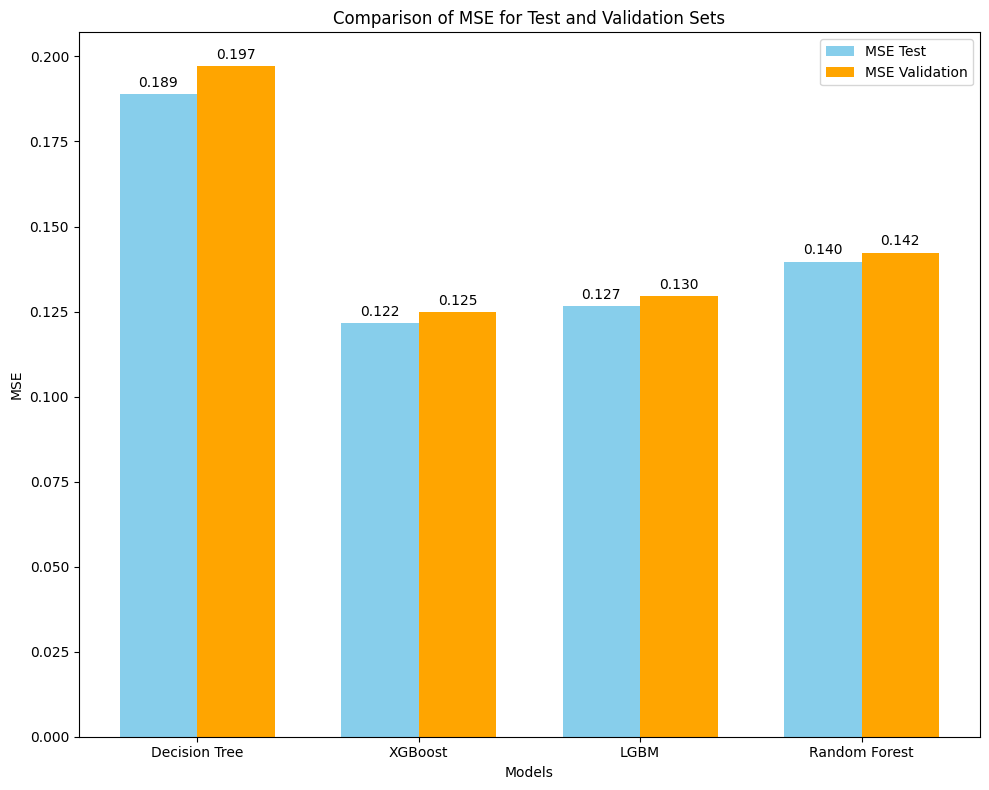

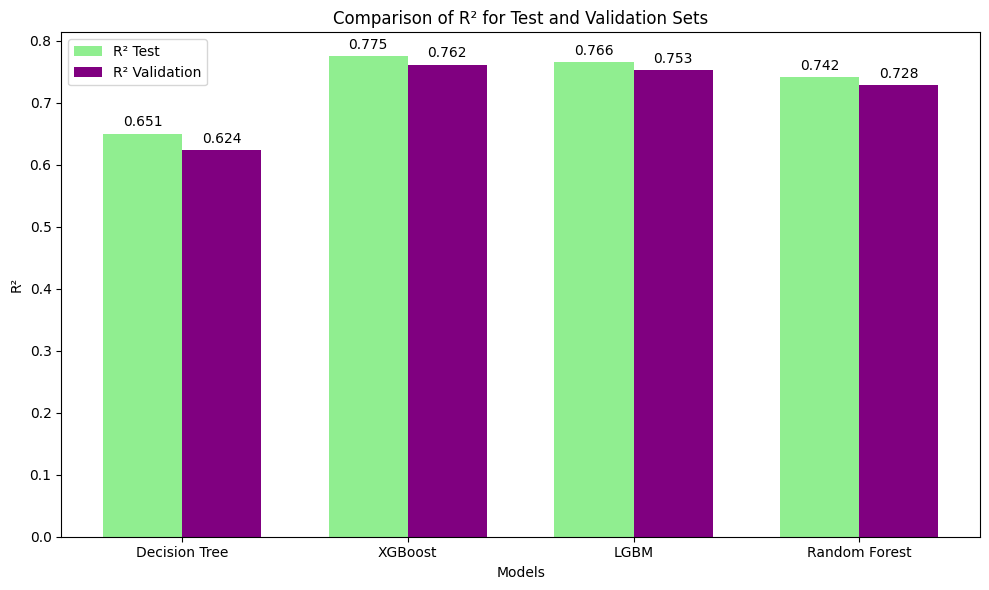

In [50]:

from sklearn.ensemble import VotingRegressor

# Rezultatele algoritmilor
models = ['Decision Tree', 'XGBoost', 'LGBM', 'Random Forest']
mse_test = [mse_val_dt, mse_val_xgb, mse_val_lgbm, mse_val_forest]
r2_test = [r2_val_dt, r2_val_xgb, r2_val_lgbm, r2_val_forest]
mse_val = [mse_test_dt, mse_test_xgb, mse_test_lgbm, mse_test_forest]
r2_val = [r2_test_dt, r2_test_xgb, r2_test_lgbm, r2_test_forest]

# Grafic comparativ
x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 8))
bar1 = ax.bar(x - width/2, mse_test, width, label='MSE Test', color='skyblue')
bar2 = ax.bar(x + width/2, mse_val, width, label='MSE Validation', color='orange')

ax.set_xlabel('Models')
ax.set_ylabel('MSE')
ax.set_title('Comparison of MSE for Test and Validation Sets')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Adaugă valori pe bare
for bar in bar1 + bar2:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Grafic pentru R²
fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(x - width/2, r2_test, width, label='R² Test', color='lightgreen')
bar2 = ax.bar(x + width/2, r2_val, width, label='R² Validation', color='purple')

ax.set_xlabel('Models')
ax.set_ylabel('R²')
ax.set_title('Comparison of R² for Test and Validation Sets')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Adaugă valori pe bare
for bar in bar1 + bar2:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

plt.tight_layout()
plt.show()